# Initialize ALL THE THINGS!

In [2]:
%matplotlib inline
from allensdk.core.cell_types_cache import CellTypesCache
import matplotlib as mpl # I don't think I'm using this
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA


# Lowest possible amplitude

In [3]:
def lowest_possible_amplitude(specimen_id,sweep_type):
    features = ctc.get_ephys_sweeps(specimen_id)
    sweep_list=[]
    sweep_stim_amp=[]
    for f in range(len(features)):
        if features[f]['stimulus_name'] == sweep_type:
            if features[f]['num_spikes'] > 0:
                sweep_list.append([features[f]['sweep_number'],f])
    for f in range(len(sweep_list)):
        sweep_stim_amp.append([sweep_list[f][0],features[sweep_list[f][1]]['stimulus_absolute_amplitude']])
        sweep_stim_amp.sort()
    return sweep_stim_amp[-1][0]

# Lowest possible amplitude resting potential

In [4]:
def sweep_resting_potential(f):
    features = ctc.get_ephys_sweeps(df1['id'].iloc[f])
    for i in range(len(features)):
        if features[i]['sweep_number'] == df1['SS_Threshold_Sweep'].iloc[f]:
            return features[i]['pre_vm_mv']

# Max Voltage

In [5]:
def peak_voltage(spec_id, sweep_number):
    data_set = ctc.get_ephys_data(spec_id)
    sweep_data = data_set.get_sweep(sweep_number)
    return max(sweep_data["response"])

# Threshold Time

In [6]:
def get_threshold_time(spec_id,sweep):
    import h5py, os
    data_set = ctc.get_ephys_data(spec_id)
    f = h5py.File(data_set.file_name,'r')
    spike_times = f['analysis']['aibs_spike_times']['Sweep_%d' % sweep].value
    f.close()
    return spike_times

# Build up Pandas DataFrame

In [4]:
ctc = CellTypesCache(manifest_file='F:\cell_types\manifest.json')

df1=pd.DataFrame(ctc.get_cells())
cell_index=ctc.get_cells()
df1['Cre_Line'] =  np.array([cell_index[f]['donor']['transgenic_lines'][0]['name'] for f in range(len(cell_index))])

#correct for some specimens having the driver and reporter lines swapped
for f in range(len(cell_index)):
    if cell_index[f]['donor']['transgenic_lines'][0]['name'] == 'Ai14':
        df1['Cre_Line'][f] = cell_index[f]['donor']['transgenic_lines'][1]['name']
        
#Add updown ratio to df
df1['Updown'] = np.array([cell_index[f]['ephys_features'][0]['upstroke_downstroke_ratio_long_square'] for f in range(len(cell_index))])

df1['Layer'] = np.array([cell_index[f]['structure']['name'].split()[-1] for f in range(len(cell_index))])

cre_lines=np.unique(df1['Cre_Line'])
locations= np.unique(df1['Layer'])

cre_line_x = np.array([np.where(cre_lines==f) for f in df1.Cre_Line])
layer_x_locations=np.array([np.where(locations==f) for f in df1.Layer])

cre_line_x.shape=(248)
layer_x_locations.shape=(248)

df1['cre_line_x']=cre_line_x
df1['layer_x_locations']=layer_x_locations

#cre_lines_corrected = ['Rorb','Scnn1a-Tg2','Nr5a1','Scnn1a','Rbp4','Ntsr1','Gad2', 'Htr3a', 'PV','Sst']
#cre_line =np.array(['Rorb-IRES2-Cre','Scnn1a-Tg2-Cre','Nr5a1-Cre','Scnn1a-Tg3-Cre','Rbp4-Cre_KL100','Ntsr1-Cre','Gad2-IRES-Cre','Htr3a-Cre_NO152','Pvalb-IRES-Cre','Sst-IRES-Cre'])

#df1['cre_line_x'] = np.array([np.where(cre_line==f) for f in df1.Cre_Line])
#df1['layer_x_locations'] = np.array([np.where(locations==f) for f in df1.Layer])


C:\Users\aaronoldre\Anaconda\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Plot SS for every cell
look for the short square response for every cell in the data set to see if there is eigenvalue distrbution
start plot at start of stimulus and go 10 ms beyond stimulus to allow recovery
Do the graphs need to be normalized?
Do I need to look at just one sweep per experiment or average all sweeps that fired?
Is this worth looking at in ramps and long square to see same pattern?

In [5]:
#remove ids that spike counter is missing
df1 = df1[df1.id != 319070795]
df1 = df1[df1.id != 341016267]

In [11]:
df1['SS_Threshold_Sweep']=np.array([lowest_possible_amplitude(df1['id'].iloc[f],'Short Square') for f in range(len(df1))])
df1['Resting_Potential']=np.array([sweep_resting_potential(f) for f in range(len(df1))])
df1['Peak_Voltage']=np.array([peak_voltage(df1['id'].iloc[f],df1['SS_Threshold_Sweep'].iloc[f]) for f in range(len(df1))])
df1['Threshold_Time']=np.array([get_threshold_time(df1['id'].iloc[f],df1['SS_Threshold_Sweep'].iloc[f]) for f in range(len(df1))])
df1['Delta_threshold']=np.array([df1['Threshold_Time'].iloc[f]-1.0203 for f in range(len(df1))])

# Save the DataFrame as HDF5 to Save Time

In [12]:
df1.save('data_frame.h5')


C:\Users\aaronoldre\Anaconda\lib\site-packages\pandas\core\generic.py:1000: FutureWarning: save is deprecated, use to_pickle
  warnings.warn("save is deprecated, use to_pickle", FutureWarning)


# Load DataFrame from here

In [7]:
df1=np.load('data_frame.h5')
#df_PV=df1(df1.Cre_Line=='Pvalb-IRES-Cre').copy()
ctc = CellTypesCache(manifest_file='F:\cell_types\manifest.json')

# Plot Minimum Current that Elicits a Spike in SS

In [8]:
df1.keys()

Index([                u'apical',    u'cell_soma_locations',
                    u'data_sets',          u'dendrite_type',
                        u'donor',               u'donor_id',
               u'ephys_features',        u'ephys_result_id',
       u'external_specimen_name',           u'failed_facet',
               u'has_morphology',     u'has_reconstruction',
                   u'hemisphere',                     u'id',
             u'is_cell_specimen',                 u'is_ish',
                         u'name', u'neuron_reconstructions',
                    u'parent_id',         u'parent_x_coord',
               u'parent_y_coord',         u'parent_z_coord',
         u'rna_integrity_number',       u'specimen_id_path',
                u'specimen_tags',              u'sphinx_id',
                    u'structure',           u'structure_id',
                    u'tissue_ph',                 u'weight',
                     u'Cre_Line',                 u'Updown',
                        

# Normalize the Output
add another column to the dataframe that contains the spike time
use pre_vm_mv to align to resting potential
shift spikes so align the spike threshold to end of stimulus

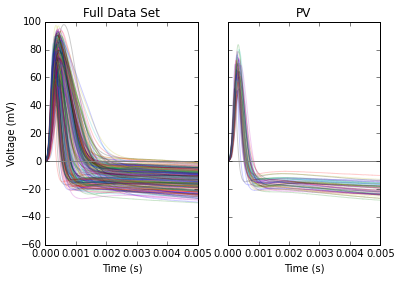

In [43]:
#Put full data set adjacent to the PV cells
def get_sweep_v_i_t_from_set(spec_id, sweep_number):
    data_set = ctc.get_ephys_data(spec_id)
    sweep_data = data_set.get_sweep(sweep_number)
    v = sweep_data["response"] # in V
    v *= 1e3 # to mV
    sampling_rate = sweep_data["sampling_rate"] # in Hz
    spike_time=int(get_threshold_time(spec_id,sweep_number)*sampling_rate)
    v[:] = [x +(-v[spike_time]) for x in v]
    v=v[spike_time:]
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)
    return v, t

f,(ax1,ax2) = plt.subplots(1,2,sharey=True)

for s in range(len(df1)):
    time_window = 0.005
    v, t = get_sweep_v_i_t_from_set(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
    if df1['Cre_Line'].iloc[s]=='Pvalb-IRES-Cre':
        ax2.plot(t,v,alpha=.2)
        ax2.plot(t, color='gray')
        ax2.set_xlim(0,time_window)
    ax1.plot(t, v,alpha=.2)
    ax1.plot(t, color='gray')
    ax1.set_xlim(0,time_window)

ax1.set_ylabel("Voltage (mV)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax1.set_title('Full Data Set')
ax2.set_title('PV')

# PCA (principle component analysis)

In [10]:
def normalized_sweep_PCA(spec_id, sweep_number):
    data_set = ctc.get_ephys_data(spec_id)
    sweep_data = data_set.get_sweep(sweep_number)
    v = sweep_data["response"] # in V
    v *= 1e3 # to mV
    sampling_rate = sweep_data["sampling_rate"] # in Hz
    spike_time=int(get_threshold_time(spec_id,sweep_number)*sampling_rate)
    v[:] = [x +(-v[spike_time]) for x in v]
    v=v[spike_time:spike_time+1000]
    return v
    

In [11]:
s=0
PCA_array = np.empty((len(df1),1000))
PCA_array_PV = np.empty((51,1000))
PCA_array_Tg2 = np.empty((17,1000))
PCA_array_Tg3 = np.empty((36,1000))
PCA_array_Rorb = np.empty((31,1000))
PCA_array_Rbp4 = np.empty((12,1000))
PCA_array_Nr5a1 = np.empty((30,1000))
PCA_array_Ntsr1 = np.empty((8,1000))
PCA_array_Gad2 = np.empty((12,1000))
PCA_array_Htr3a = np.empty((15,1000))
PCA_array_Sst = np.empty((36,1000))
PCA_array_Ext = np.empty((17+31+36+12+30+8,1000))
PCA_array_Inb = np.empty((51+12+15+36,1000))
s1=0
s2=0
s3=0
s4=0
s5=0
s6=0
s7=0
s8=0
s9=0
s10=0
for s in range(len(df1)):
    PCA_array[s,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
    if df1['Cre_Line'].iloc[s] == 'Pvalb-IRES-Cre':
        PCA_array_PV[s1,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
        s1 +=1
    if df1['Cre_Line'].iloc[s] == 'Gad2_IRES-Cre':
        PCA_array_Gad2[s2,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
        s2 +=1
    if df1['Cre_Line'].iloc[s] == 'Rorb-IRES-Cre':
        PCA_array_Rorb[s3,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
        s3 +=1
    if df1['Cre_Line'].iloc[s] == 'Scnn1a-Tg2-Cre':
        PCA_array_Tg2[s4,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
        s4 +=1
    if df1['Cre_Line'].iloc[s] == 'Scnn1a-Tg3-Cre':
        PCA_array_Tg3[s5,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
        s5 +=1
    if df1['Cre_Line'].iloc[s] == 'Nr5a1-Cre':
        PCA_array_Nr5a1[s6,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
        s6 +=1
    if df1['Cre_Line'].iloc[s] == 'Rbp4-Cre_KL100':
        PCA_array_Rbp4[s7,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
        s7 +=1
    if df1['Cre_Line'].iloc[s] == 'Ntsr1-Cre':
        PCA_array_Ntsr1[s8,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
        s8 +=1
    if df1['Cre_Line'].iloc[s] == 'Htr3a-Cre_NO152':
        PCA_array_Htr3a[s9,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
        s9 +=1
    if df1['Cre_Line'].iloc[s] == 'Sst-IRES-Cre':
        PCA_array_Sst[s10,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Threshold_Sweep'].iloc[s])
        s10 +=1
np.save('ephys_ss_PCA.npy',PCA_array)
np.save('ephys_ss_PCA_PV.npy',PCA_array_PV)
np.save('ephys_ss_PCA_Tg2.npy',PCA_array_Tg2)
np.save('ephys_ss_PCA_Tg3.npy',PCA_array_Tg3)
np.save('ephys_ss_PCA_Rorb.npy',PCA_array_Rorb)
np.save('ephys_ss_PCA_Rbp4.npy',PCA_array_Rbp4)
np.save('ephys_ss_PCA_Sst.npy',PCA_array_Sst)
np.save('ephys_ss_PCA_Gad2.npy',PCA_array_Gad2)
np.save('ephys_ss_PCA_Htr3a.npy',PCA_array_Htr3a)
np.save('ephys_ss_PCA_Nr5a1.npy',PCA_array_Nr5a1)
np.save('ephys_ss_PCA_Ntsr1.npy',PCA_array_Ntsr1)

In [24]:
np.save('ephys_ss_PCA.npy',PCA_array)
np.save('ephys_ss_PCA_PV.npy',PCA_array_PV)
np.save('ephys_ss_PCA_Tg2.npy',PCA_array_Tg2)
np.save('ephys_ss_PCA_Tg3.npy',PCA_array_Tg3)
np.save('ephys_ss_PCA_Rorb.npy',PCA_array_Rorb)
np.save('ephys_ss_PCA_Rbp4.npy',PCA_array_Rbp4)
np.save('ephys_ss_PCA_Sst.npy',PCA_array_Sst)
np.save('ephys_ss_PCA_Gad2.npy',PCA_array_Gad2)
np.save('ephys_ss_PCA_Htr3a.npy',PCA_array_Htr3a)
np.save('ephys_ss_PCA_Nr5a1.npy',PCA_array_Nr5a1)
np.save('ephys_ss_PCA_Ntsr1.npy',PCA_array_Ntsr1)

#Perform PCA on both Arrays

In [57]:
PCA_array = np.load('ephys_ss_PCA.npy')
PCA_array_PV = np.load('ephys_ss_PCA_PV.npy')

In [58]:
model = PCA(10)
model_PV = PCA(10)

In [59]:
model.fit(PCA_array)
model_PV.fit(PCA_array_PV)


PCA(copy=True, n_components=10, whiten=False)

# Compare Time Shifted Components

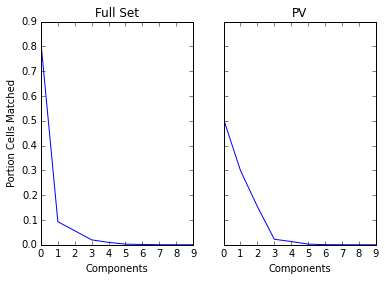

In [60]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
ax1.plot(model.explained_variance_ratio_)
ax2.plot(model_PV.explained_variance_ratio_)
ax1.set_xlabel('Components')
ax2.set_xlabel('Components')
ax1.set_title('Full Set')
ax2.set_title('PV')
ax1.set_ylabel('Portion Cells Matched')


##### mean centered voltage (mv)

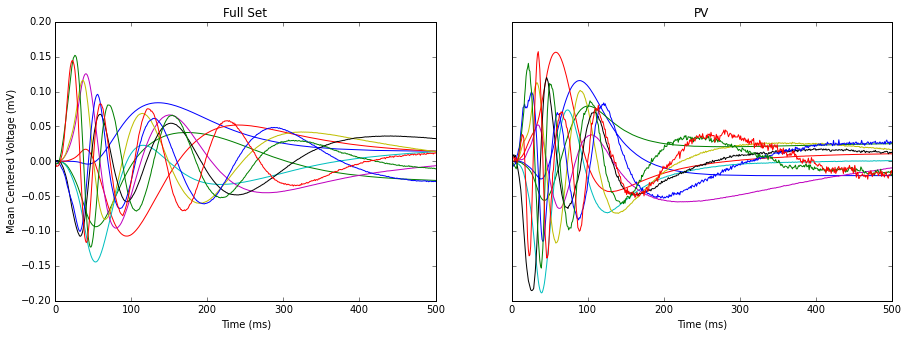

In [71]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(15,5))
plt.title('PCA')
ax1.set_title('Full Set')
ax2.set_title('PV')
ax1.set_xlim(0,500)
ax1.plot([2000,2200],[-.12,-.12],'k')
ax2.set_xlim(0,500)
ax1.plot(model.components_.T);
ax1.set_ylabel('Mean Centered Voltage (mV)')
ax1.set_xlabel('Time (ms)')
ax2.set_xlabel('Time (ms)')
ax2.plot(model_PV.components_.T);
#plt.savefig("PCA.png") 

In [65]:
mean_spike = np.mean(PCA_array,0)
mean_spike_PV = np.mean(PCA_array_PV,0)


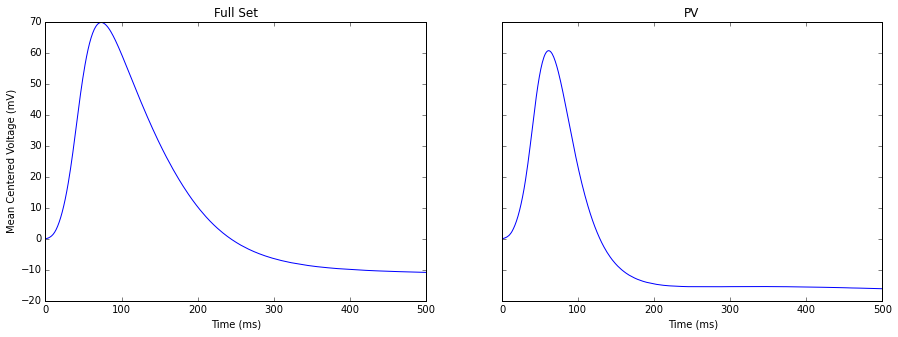

In [73]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(15,5))
plt.title('PCA')
ax1.set_title('Full Set')
ax2.set_title('PV')
ax1.set_xlim(0,500)

ax2.set_xlim(0,500)
ax1.plot(mean_spike)
ax1.set_ylabel('Mean Centered Voltage (mV)')
ax1.set_xlabel('Time (ms)')
ax2.set_xlabel('Time (ms)')
ax2.plot(mean_spike_PV)

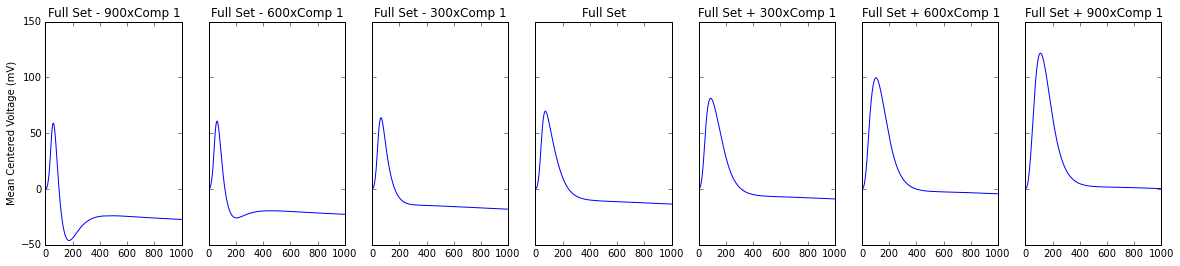

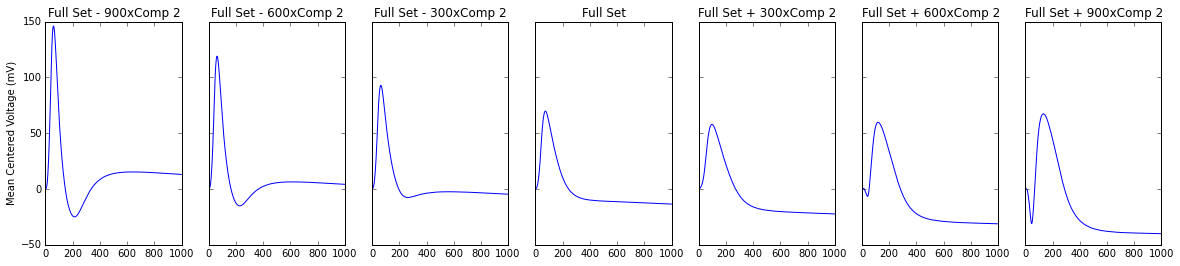

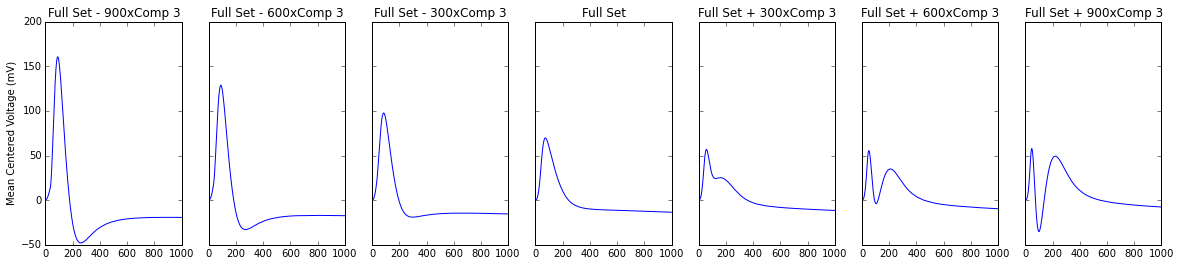

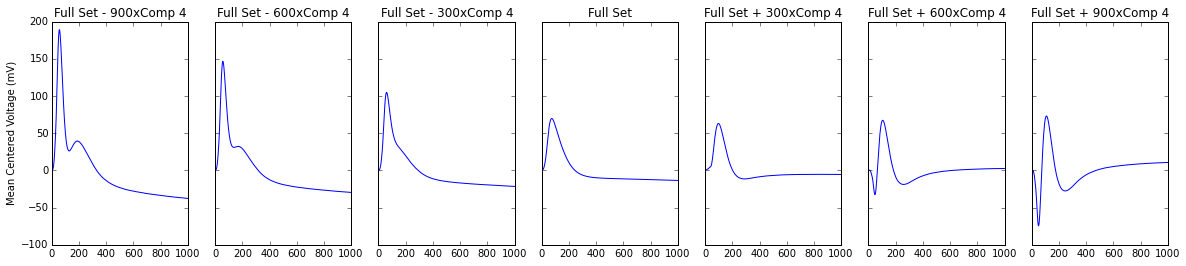

In [86]:
mean_spike = np.mean(PCA_array,0)
for i in range(4):
    f,(ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1,7,sharey=True,figsize=(20,4))
    ax1.plot(mean_spike-900*model.components_[i])
    ax2.plot(mean_spike-600*model.components_[i])
    ax3.plot(mean_spike-300*model.components_[i])
    ax4.plot(mean_spike)
    ax5.plot(mean_spike+300*model.components_[i])
    ax6.plot(mean_spike+600*model.components_[i])
    ax7.plot(mean_spike+900*model.components_[i])
    ax1.set_title('Full Set - 900xComp '+str(i+1))
    ax2.set_title('Full Set - 600xComp '+str(i+1))
    ax3.set_title('Full Set - 300xComp '+str(i+1))
    ax4.set_title('Full Set')
    ax5.set_title('Full Set + 300xComp '+str(i+1))
    ax6.set_title('Full Set + 600xComp '+str(i+1))
    ax7.set_title('Full Set + 900xComp '+str(i+1))
    ax1.set_ylabel('Mean Centered Voltage (mV)')

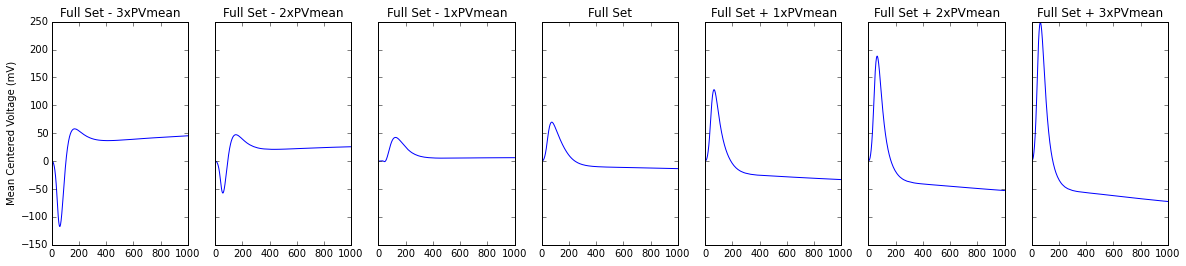

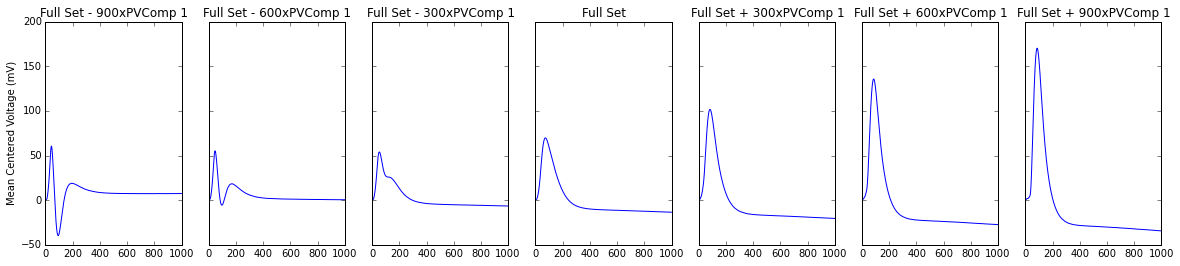

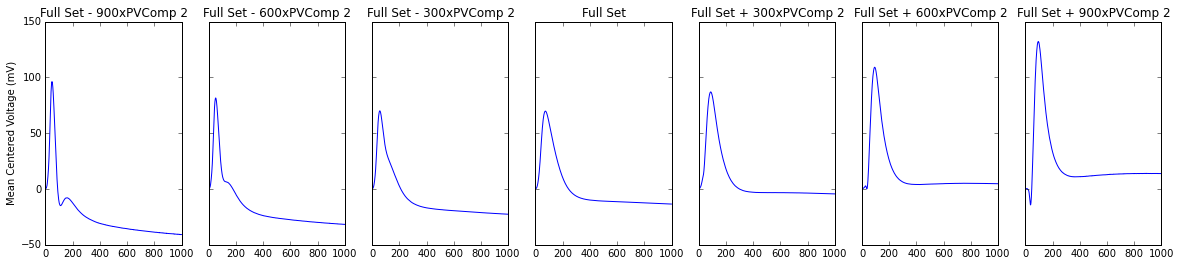

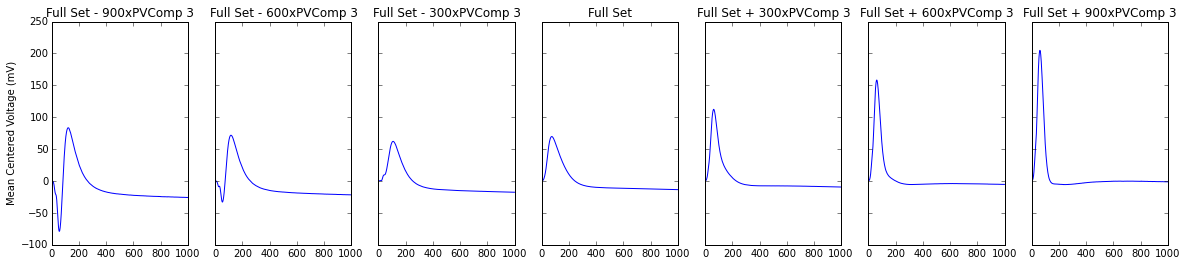

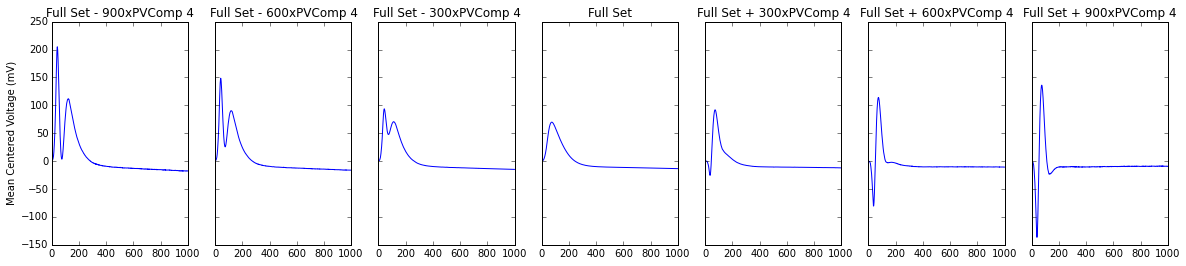

In [84]:
f,(ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1,7,sharey=True,figsize=(20,4))
ax1.plot(mean_spike-3*mean_spike_PV)
ax2.plot(mean_spike-2*mean_spike_PV)
ax3.plot(mean_spike-1*mean_spike_PV)
ax4.plot(mean_spike)
ax5.plot(mean_spike+1*mean_spike_PV)
ax6.plot(mean_spike+2*mean_spike_PV)
ax7.plot(mean_spike+3*mean_spike_PV)
ax1.set_title('Full Set - 3xPVmean')
ax2.set_title('Full Set - 2xPVmean')
ax3.set_title('Full Set - 1xPVmean')
ax4.set_title('Full Set')
ax5.set_title('Full Set + 1xPVmean')
ax6.set_title('Full Set + 2xPVmean')
ax7.set_title('Full Set + 3xPVmean')
ax1.set_ylabel('Mean Centered Voltage (mV)')


for i in range(4):
    f,(ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1,7,sharey=True,figsize=(20,4))
    ax1.plot(mean_spike-900*model_PV.components_[i])
    ax2.plot(mean_spike-600*model_PV.components_[i])
    ax3.plot(mean_spike-300*model_PV.components_[i])
    ax4.plot(mean_spike)
    ax5.plot(mean_spike+300*model_PV.components_[i])
    ax6.plot(mean_spike+600*model_PV.components_[i])
    ax7.plot(mean_spike+900*model_PV.components_[i])
    ax1.set_title('Full Set - 900xPVComp '+str(i+1))
    ax2.set_title('Full Set - 600xPVComp '+str(i+1))
    ax3.set_title('Full Set - 300xPVComp '+str(i+1))
    ax4.set_title('Full Set')
    ax5.set_title('Full Set + 300xPVComp '+str(i+1))
    ax6.set_title('Full Set + 600xPVComp '+str(i+1))
    ax7.set_title('Full Set + 900xPVComp '+str(i+1))
    ax1.set_ylabel('Mean Centered Voltage (mV)')


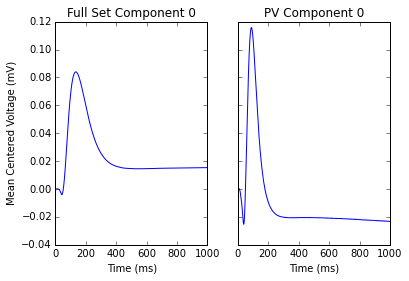

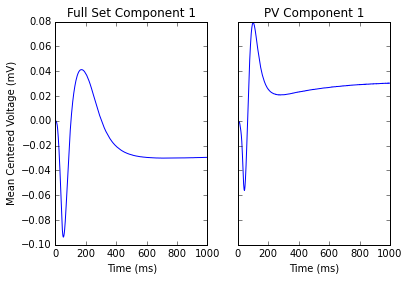

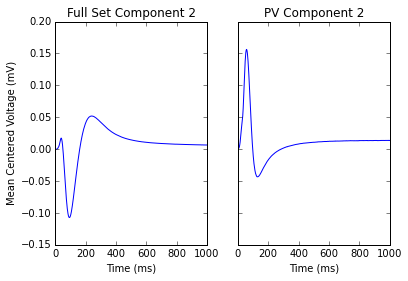

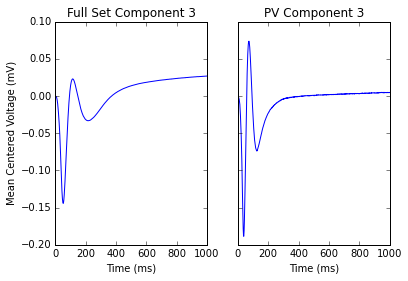

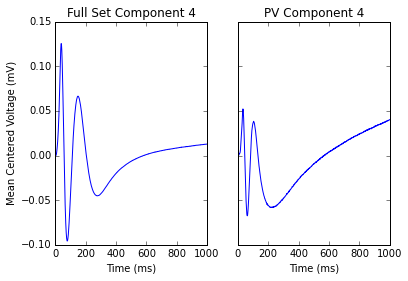

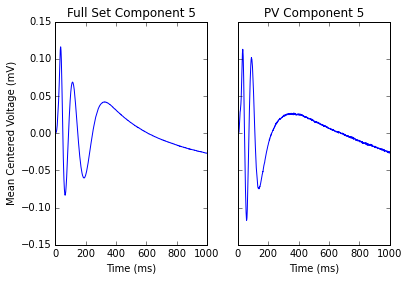

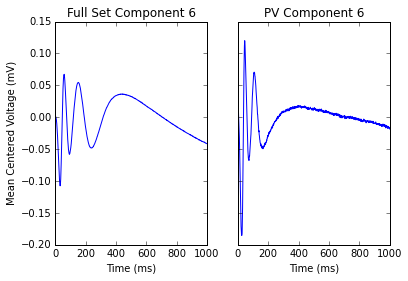

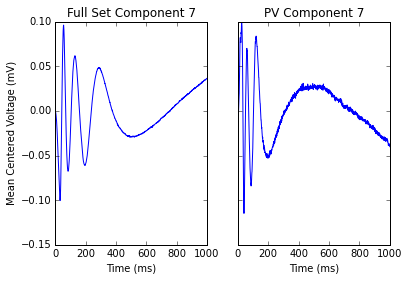

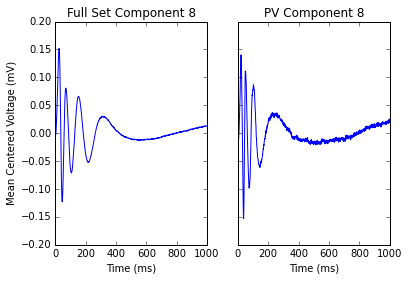

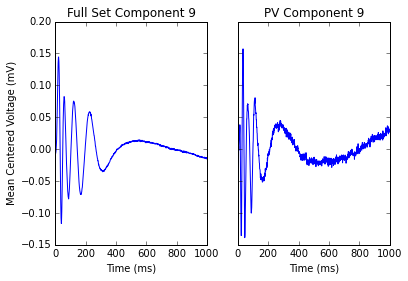

In [63]:

for i in range(10):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
    ax1.plot(model.components_[i])
    ax2.plot(model_PV.components_[i])
    ax1.set_title('Full Set Component '+ str(i))
    ax2.set_title('PV Component '+ str(i))
    ax1.set_ylabel('Mean Centered Voltage (mV)')
    ax1.set_xlim(0,1000)
    ax2.set_xlim(0,1000)
    ax1.set_xlabel('Time (ms)')
    ax2.set_xlabel('Time (ms)')

In [30]:
lowd = model.transform(PCA_array)

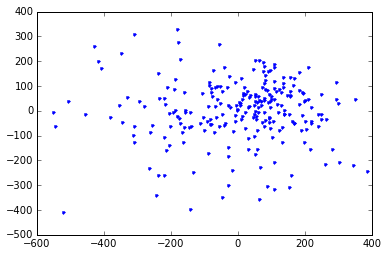

In [31]:
plt.plot(lowd[:,2], lowd[:,3], '.')
#plt.savefig("weighted.png") 

In [166]:
from sklearn.manifold import TSNE

In [167]:
model = TSNE(n_components=2)

In [168]:
model.fit(PCA_array)

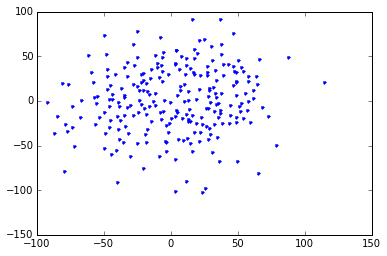

In [169]:
plt.plot(model.embedding_[:,0], model.embedding_[:,1],'.')

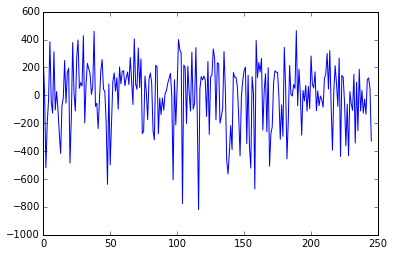

In [32]:
Aaron=model.transform(PCA_array)
plt.plot(Aaron[:,1])
#plt.savefig("weights.png") 

In [181]:
df1['Component_1']=model.transform(PCA_array)[:,1]
df1['Component_2']=model.transform(PCA_array)[:,2]
df1['Component_3']=model.transform(PCA_array)[:,3]
#df1.save('data_frame.h5')

In [184]:
df1.keys()


Index([                u'apical',    u'cell_soma_locations',
                    u'data_sets',          u'dendrite_type',
                        u'donor',               u'donor_id',
               u'ephys_features',        u'ephys_result_id',
       u'external_specimen_name',           u'failed_facet',
               u'has_morphology',     u'has_reconstruction',
                   u'hemisphere',                     u'id',
             u'is_cell_specimen',                 u'is_ish',
                         u'name', u'neuron_reconstructions',
                    u'parent_id',         u'parent_x_coord',
               u'parent_y_coord',         u'parent_z_coord',
         u'rna_integrity_number',       u'specimen_id_path',
                u'specimen_tags',              u'sphinx_id',
                    u'structure',           u'structure_id',
                    u'tissue_ph',                 u'weight',
                     u'Cre_Line',                 u'Updown',
                        

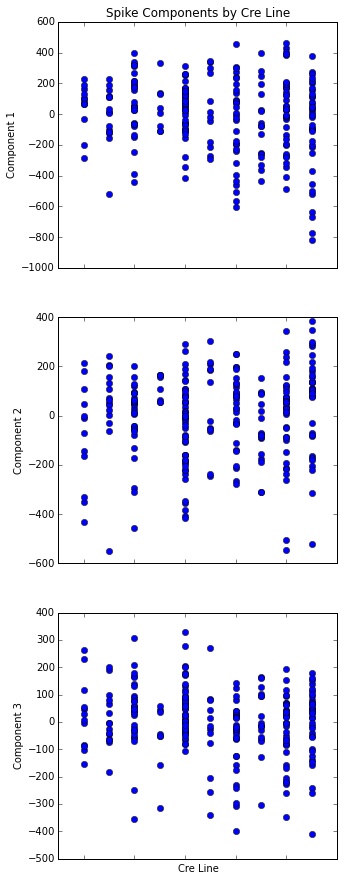

In [39]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(5,15))
ax1.set_title('Spike Components by Cre Line')
ax1.set_ylabel('Component 1')
ax1.set_xlim(-1,10)
ax2.set_xlim(-1,10)
ax3.set_xlim(-1,10)
ax1.plot(df1['cre_line_x'],df1['Component_1'],marker='o',linestyle='none')
ax2.plot(df1['cre_line_x'],df1['Component_2'],marker='o',linestyle='none')
ax3.plot(df1['cre_line_x'],df1['Component_3'],marker='o',linestyle='none')
ax2.set_ylabel('Component 2')
ax3.set_ylabel('Component 3')
ax3.set_xlabel('Cre Line')
ax3.tick_params(labelbottom='off')
#plt.savefig('components_cre.png')
#df1.plot(x='cre_line_x',y='Updown',marker='o',linestyle='none',ax=ax,xlim=(-1,11),ylim=(0,6))

# Let's add this to all the other spikes

In [12]:
features=ctc.get_ephys_sweeps(df1['id'][0])
features[0]
([np.where(cre_lines==f) for f in df1.Cre_Line])
#spikey_sweeps = np.array([features[f]['sweep_number']np.where(features[f]['num_spikes']>0) for f in features]

[(array([9], dtype=int64),),
 (array([8], dtype=int64),),
 (array([9], dtype=int64),),
 (array([8], dtype=int64),),
 (array([8], dtype=int64),),
 (array([8], dtype=int64),),
 (array([5], dtype=int64),),
 (array([7], dtype=int64),),
 (array([2], dtype=int64),),
 (array([1], dtype=int64),),
 (array([7], dtype=int64),),
 (array([9], dtype=int64),),
 (array([8], dtype=int64),),
 (array([4], dtype=int64),),
 (array([2], dtype=int64),),
 (array([8], dtype=int64),),
 (array([7], dtype=int64),),
 (array([7], dtype=int64),),
 (array([0], dtype=int64),),
 (array([6], dtype=int64),),
 (array([8], dtype=int64),),
 (array([1], dtype=int64),),
 (array([9], dtype=int64),),
 (array([1], dtype=int64),),
 (array([3], dtype=int64),),
 (array([2], dtype=int64),),
 (array([7], dtype=int64),),
 (array([2], dtype=int64),),
 (array([6], dtype=int64),),
 (array([9], dtype=int64),),
 (array([8], dtype=int64),),
 (array([8], dtype=int64),),
 (array([4], dtype=int64),),
 (array([1], dtype=int64),),
 (array([2], d

In [13]:
spikey_sweeps=np.array([features[f]['sweep_number'] for f in range(len(features))if(features[f]['num_spikes']>0)])
print spikey_sweeps

[51 73 46 58 54 68 60 33 59 66 63 69 35 57 74  4 44 62 87 61 52  6 70 83 20
 71 18 55 17 50 19 56 64 16 11 85 67 79 49 72 75]


In [14]:
get_threshold_time(df1['id'][0],4)


array([ 2.99676 ,  3.210955,  3.269275,  3.329515,  3.496945,  3.544585,
        3.59267 ,  3.640445,  3.68781 ,  3.78855 ,  3.8348  ,  3.87426 ,
        4.102845,  4.14601 ,  4.19359 ,  4.23799 ,  4.306995,  4.31949 ])

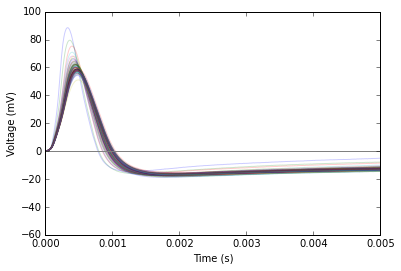

In [33]:
def spike_plotter(spec_id, sweep_number,spike_time):
    time_window=0.005
    data_set = ctc.get_ephys_data(spec_id)
    sweep_data = data_set.get_sweep(sweep_number)
    v = sweep_data["response"] # in V
    v *= 1e3 # to mV
    sampling_rate = sweep_data["sampling_rate"] # in Hz
    spike_time=spike_time*sampling_rate
    v[:] = [x +(-v[spike_time]) for x in v]
    v=v[spike_time:]
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)
    return v, t

def spswp_resting_potential(spec,sweep):
    features = ctc.get_ephys_sweeps(spec)
    for i in range(len(features)):
        if features[i]['sweep_number'] == sweep:
            return features[i]['pre_vm_mv']
        

fig, axes = plt.subplots(1, 1, sharex=True)
for f in range(len(spikey_sweeps[0:1])):
    spike_times=get_threshold_time(df1['id'][0],spikey_sweeps[f])
    for i in spike_times:
        v, t = spike_plotter(df1['id'][0],spikey_sweeps[f],i)
        axes.plot(t, v,alpha=.2)
        axes.plot(t, color='gray')
        axes.set_xlim(0,0.005)
        
axes.set_ylabel("Voltage (mV)")
axes.set_xlabel("Time (s)")

#print spswp_resting_potential(df1['id'][0],spikey_sweeps[5])